# Check the stabilisation of  WOA09 salinity field in comparing it to it's original version, and convert it into SalPrac instead SA to use it in CREG025.L75 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import gsw as gsw

%matplotlib inline

In [2]:
! date

Fri Mar 14 09:31:45 CET 2025


In [3]:
gsw.conversions.SP_from_SA?

Signature: gsw.conversions.SP_from_SA(SA, p, lon, lat)
Docstring:
Calculates Practical Salinity from Absolute Salinity.

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lon : array-like
    Longitude, -360 to 360 degrees
lat : array-like
    Latitude, -90 to 90 degrees

Returns
-------
SP : array-like, unitless
    Practical Salinity  (PSS-78)
File:      /opt/linux/envs/envs/phyocean-2023.11/lib/python3.10/site-packages/gsw/_wrapped_ufuncs.py
Type:      function

>>> # get the SA first 

>>> # then the CT using the SA and pt

>>>> # UNITS CONVERSION

In [4]:
INDIR="./CREG12.L75-I/"

In [5]:
ds_inS=xr.open_mfdataset(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75_Stabilise.nc')
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [6]:
# Add the geographical coordinates
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_geo=xr.open_dataset(INDIR+'woa09_temperature_monthly_1deg.nc',decode_times=False)
ds_geo

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    climatology_bnds  (time, nv) float32 ...
    t_an              (time, depth, lat, lon) float32 ...
    t_mn              (time, depth, lat, lon) float32 ...
    t_dd              (time, depth, lat, lon) float64 ...
    t_ma              (time, depth, lat, lon) float32 ...
    t_sd              (time, depth, lat, lon) float32 ...
    t_se              (time, depth, lat, lon) float32 ...
    t_oa              (time, depth, lat, lon) float32 ...
    t_gp              (time, depth, lat, lon) float64 ...
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         75d70376-540c-4a1f-a0ca-f19f07dd7272
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Temperature ...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

In [7]:
lat=ds_geo.lat
lon=ds_geo.lon
lat2D=np.tile(lat,(lon.size,1)).T
lon2D=np.tile(lon,(lat.size,1))

In [8]:
lat2D.shape

(180, 360)

In [9]:
# Append this geo. to the WOA09 dataset 
ds_inS.coords['lat']=(('lat0','lon0'),lat2D)
ds_inS.coords['lon']=(('lat0','lon0'),lon2D)
#ds_inS.coords['lon']=(('lat0','lon0'),lon2D-180.)
#ds_inT.coords['lat']=(('lat0','lon0'),lat2D)
#ds_inT.coords['lon']=(('lat0','lon0'),lon2D-180.)

In [10]:
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [11]:
# Need also to provide a depth
INDIR="./CREG12.L75-I/"
ds_4depth=xr.open_mfdataset(INDIR+'CREG12.L75-REF06_init_gridT.nc')
depth=ds_4depth['deptht']
depth.shape

(75,)

In [12]:
# Prepare this 1D field to be duplicated 
z2dt=np.reshape(depth.values,(1,75,1,1))
z2dt.shape
zplt = np.repeat(z2dt,12,axis=0)
zplt.shape

(12, 75, 1, 1)

In [13]:
# Duplicate this depth to fit the T/S on a global grid
depth4D=np.tile(zplt,(1,1,180,360))
depth4D.shape

(12, 75, 180, 360)

In [14]:
# Define a pressure from depth
pressure=gsw.p_from_z(-depth4D,lat2D)

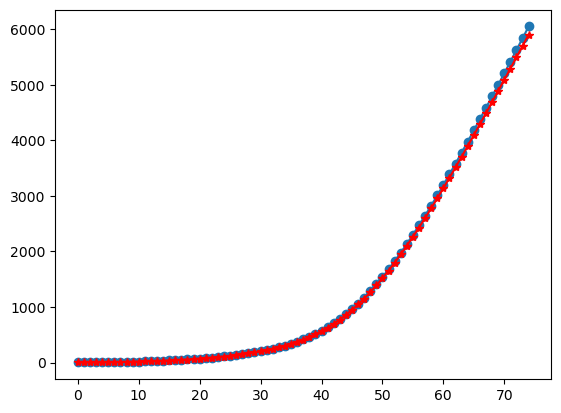

In [15]:
plt.plot(pressure[0,:,10,10],'-o')
plt.plot(depth4D[0,:,10,10],'-*',color='r')

In [16]:
# Apply the conversion
ds_SP=gsw.conversions.SP_from_SA(ds_inS['SA'],pressure,ds_inS['lon'],ds_inS['lat'] )
ds_SP.shape


(12, 75, 180, 360)

In [17]:
ds_inS['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.data)

In [18]:
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    s_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [19]:
ds_PSinit=xr.open_mfdataset(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75.nc')
ds_PSinit.coords['lat']=(('lat0','lon0'),lat2D)
ds_PSinit


<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    s_an     (time_counter, z, lat0, lon0) float32 dask.array<chunksize=(1, 38, 90, 180), meta=np.ndarray>
Attributes:
    description:  WOA09 field for the 1degx1deg grid with duplicated levelswi...

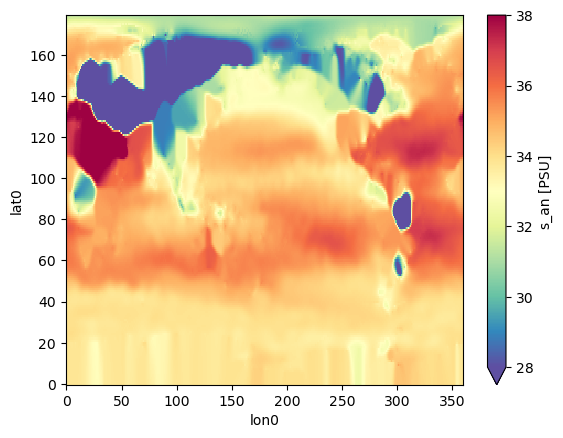

In [20]:
ds_PSinit.s_an.isel(time_counter=0,z=0).plot(vmin=28.,vmax=38.,cmap='Spectral_r')

Text(0.5, 1.0, 'New-init at depth 412.0 m')

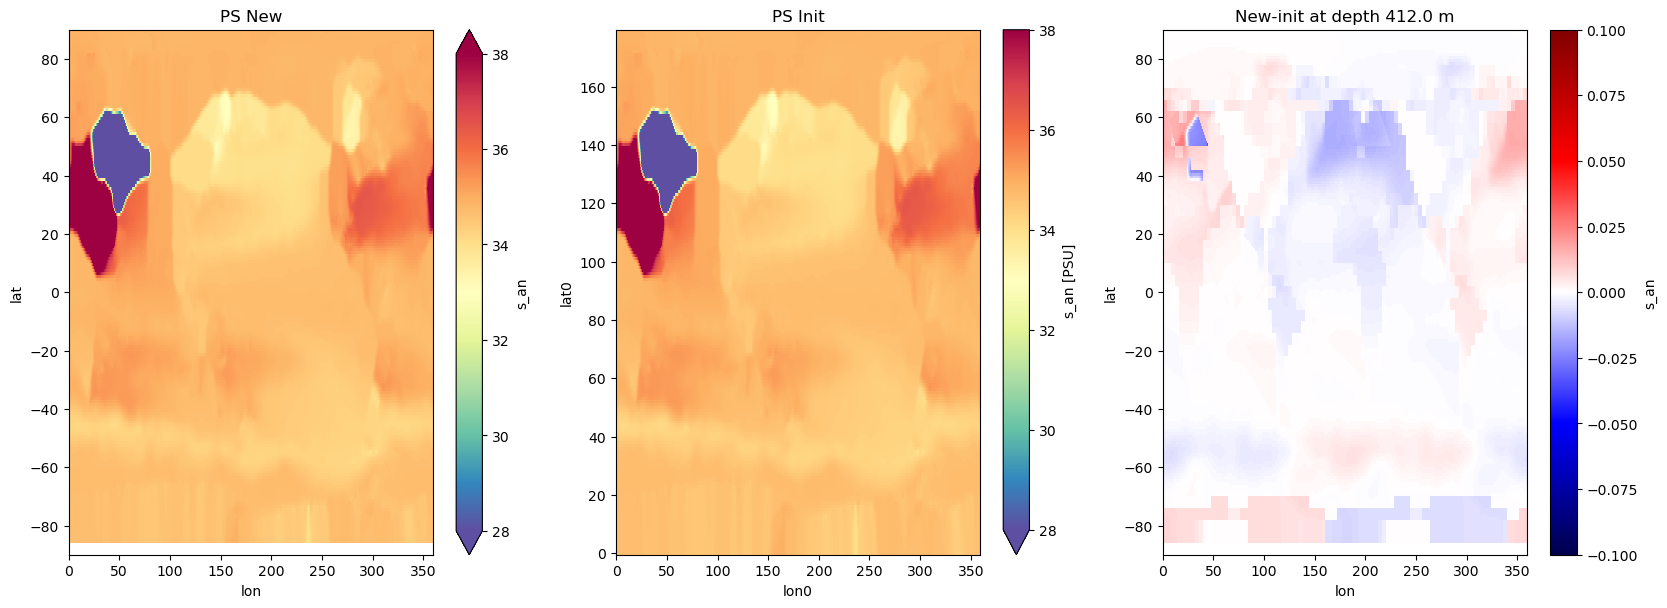

In [22]:
# Control 2D the final result
it=0 ; iz=37 

plt.figure(figsize=(20,15))
plt.subplot(231)
ds_inS['s_an'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('PS New')

plt.subplot(232)
ds_PSinit['s_an'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon0',y='lat0')
#ds_SA.isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('PS Init')

plt.subplot(233)
(ds_inS['s_an'].isel(time_counter=it,z=iz)-ds_PSinit['s_an'].isel(time_counter=it,z=iz)).\
plot(vmin=-1e-1,vmax=1e-1,cmap='seismic',x='lon',y='lat')
plt.title('New-init at depth '+str(np.round(depth4D[0,iz,0,0]))+' m')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


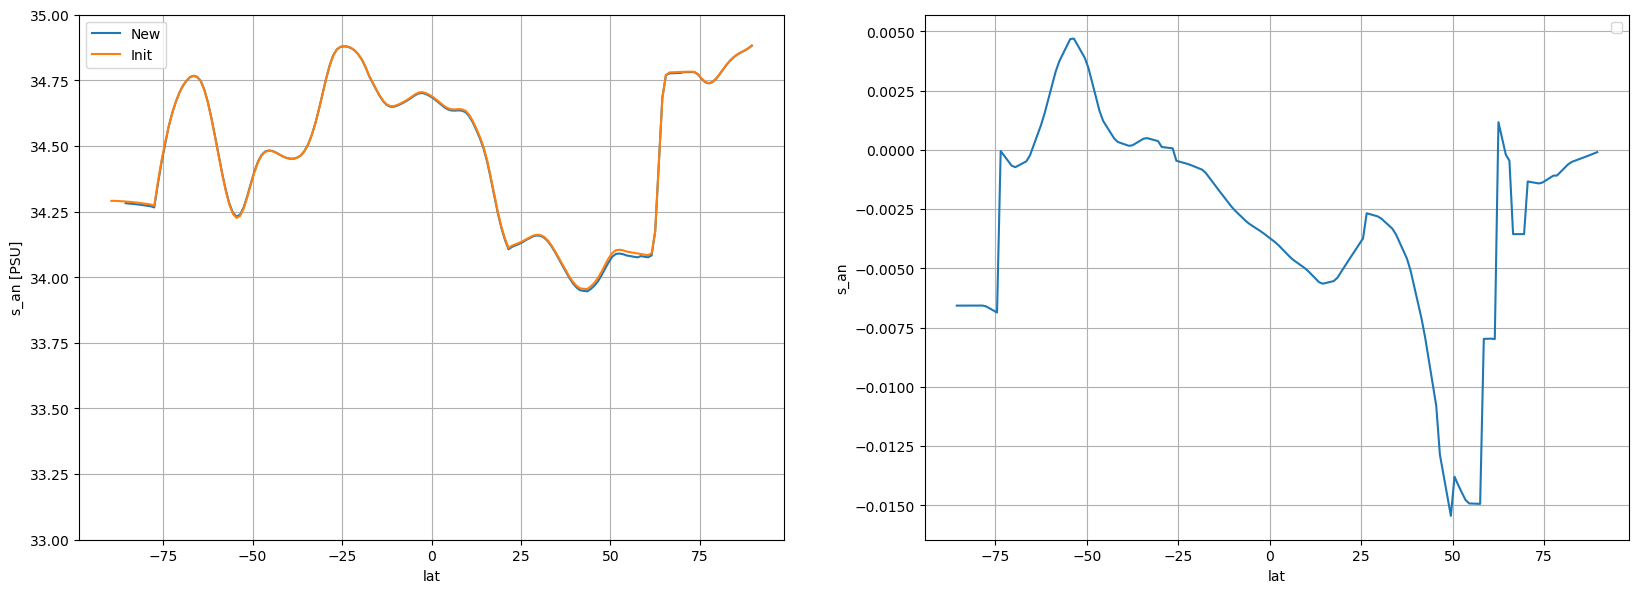

In [25]:
# Control the final result along a given longitude
it=5 ; iz=37 ; ilon=200

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='New',x='lat')
ds_PSinit['s_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='Init',x='lat')
#plt.xlim([0,180])
plt.ylim([33,35])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon)-ds_PSinit['s_an'].\
 isel(time_counter=it,z=iz,lon0=ilon)).plot(x='lat')
#plt.xlim([0,180])
#plt.ylim([30,36])
plt.grid(True)
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


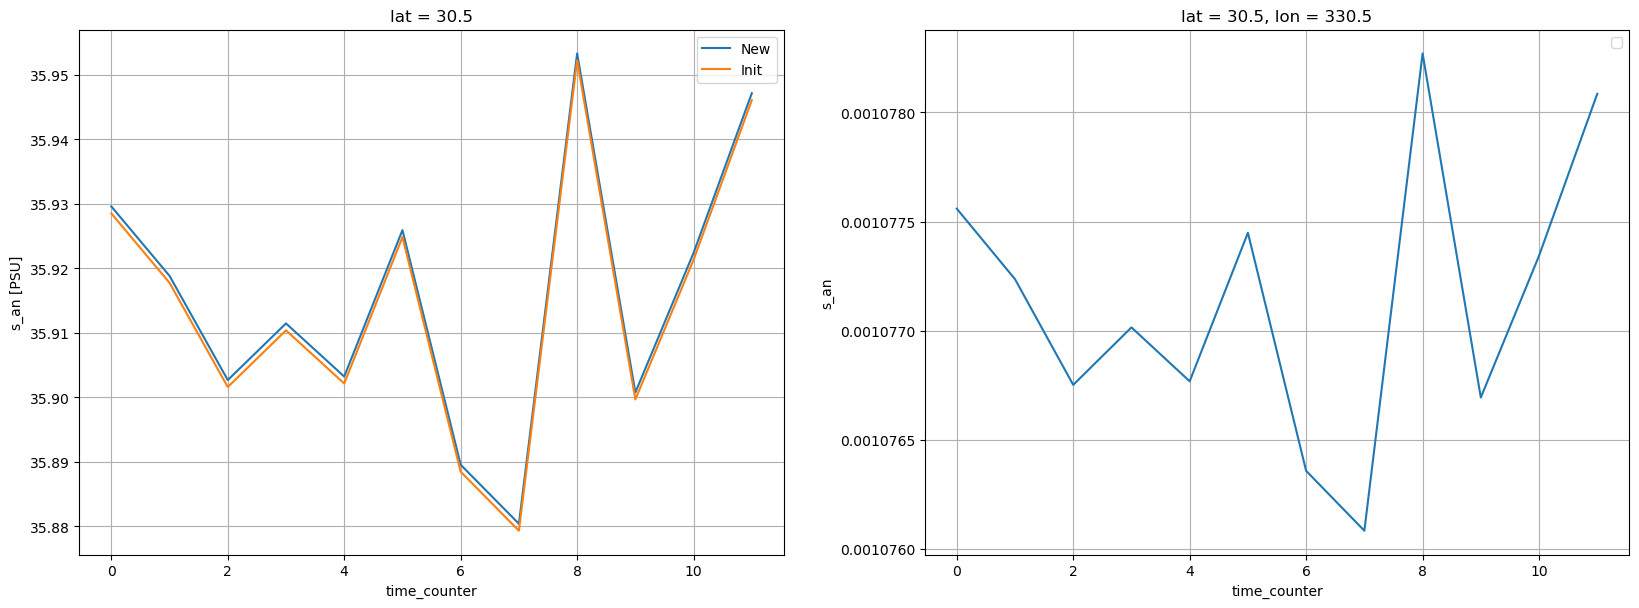

In [26]:
# Control the seasonal cycle 
ilon=330 ; ilat=120 ; iz=37 ;

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='New',x='time_counter')
ds_PSinit['s_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='Init',x='time_counter')
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat)-ds_PSinit['s_an'].isel(z=iz,lon0=ilon,lat0=ilat)).plot(x='time_counter')
plt.grid(True)
plt.legend()



# Output new fields 

In [29]:
if True:
    INDIR="./CREG12.L75-I/"
    ds_out=xr.Dataset()
    # Save WOA09 Practical Salinity 
    ds_out['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.values)
    #ds_out['lat']=(('lat0','lon0'),ds_inS['lat'].values)
    #ds_out['lon']=(('lat0','lon0'),ds_inS['lon'].values)
    ds_out.attrs['History']='This salinity field has been stabilise using GSW gsw_stabilise_SA_const_t function, i.e. without changing the temperature'
    #ds_out.to_netcdf(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75_stabilise.nc',unlimited_dims='time_counter')
    ds_out.to_netcdf(INDIR+'stabilise.nc',unlimited_dims='time_counter')